<table style="float:left; border:none">
   <tr style="border:none">
       <td style="border:none">  
           <img 
               src="assets/dh.png" 
               style="width:500px"
           >
           </a>    
       </td>
   </tr>
</table>
<div style="float:right;"><h2>07. Evaluation models</h2></div>

 <a id="top"></a> <br>
## Índice
1. [Entradas y Entregable](#1)<br>
    1.1. [Entradas del modelo](#11)<br>
    1.2. [Entregable](#12)<br>
2. [Carga de paquetes y datos](#2)<br>
    2.1. [Librerías y clases](#21)<br>
    2.2. [Lectura de datos](#22)<br>
    2.3. [Separación en train y test](#23)<br>
3. [Evaluacion de modelos](#3)<br>
    3.1. [Lectura de modelo, threshold, cost_function y metricas en shelve](#31)<br>
    3.2. [Funcion de costo](#32)<br>
    3.3. [Métricas](#33)<br>
    3.4. [Matriz de confusion](#34)<br>
    3.5. [ROC Curve](#35)<br>
    3.6. [Precision-Recall Curve](#36)<br>
4. [Conclusiones y eleccion de modelo](#4)<br>

***
<a id="1"></a> <br>
## 1. Entradas y Entregable

<a id="11"></a>
### 1.1. Entradas

|Tipo|Nombre|Descripción|Ubicación Lab|
|:-------|----------------|---------------------------------------------------|-------------------------------------|
|**csv**| `aug.csv` | datos relacionados a cada alumno que aprobo un curso |`.../archive/`|
|**db**| `02_gaussian_model.db` | archivo en shelve con salidas del notebook 02.Model-Gaussian Naive Bayes |`models_shelve/`|
|**db**| `03_ensamble_model.db` |archivo en shelve con salidas del notebook 03.Model-Ensamble |`models_shelve/`|
|**db**| `04_dtree_model.db` | archivo en shelve con salidas del notebook 04.Model-Decision Tree Classifier |`models_shelve/`|
|**db**| `05_rforest_model.db` | archivo en shelve con salidas del notebook 05.Model-Random Forest |`models_shelve/`|
|**db**| `06_lgbm_model.db` | archivo en shelve con salidas del notebook 06.Model-Light GBM |`models_shelve/`|

<a id="12"></a>
### 1.2. Entregable

1. Elección de modelo a utilizar

***
<a id="2"></a> <br>
## 2. Carga de paquetes y datos

<a id="21"></a>
### 2.1. Librerías y clases

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib. pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, fbeta_score, confusion_matrix, accuracy_score, roc_auc_score, recall_score, fbeta_score, make_scorer, f1_score, roc_curve, precision_score, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler,  FunctionTransformer, LabelEncoder, binarize
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import make_pipeline, make_union
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import tree
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline 
from catboost import CatBoostClassifier

from IPython.display import Image
import pydotplus

import shelve

import warnings
warnings.filterwarnings("ignore")

C:\Users\gtoso\anaconda3\envs\dhproyect\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Esta clase permite aislar columnas de un DataFrame dentro de un pipeline

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def transform(self, X, *_):
        if isinstance(X, pd.DataFrame):
            return pd.DataFrame(X[self.columns])
        else:
            raise TypeError("Este Transformador solo funciona en DF de Pandas")
    
    def fit(self, X, *_):
        return self

In [3]:
# Esta clase permite dropear columnas de un DataFrame dentro de un pipeline

class ColumnDropper(BaseEstimator, TransformerMixin):
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self  

<a id="22"></a> <br>
### 2.2. Lectura de datos

In [4]:
# Lectura de DataFrame con datos de candidatos
df = pd.read_csv("../archive/aug.csv")
df.sample(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
5609,8077,city_67,0.855,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Pvt Ltd,3,57,0.0
6183,23413,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,1,110,1.0
3602,17682,city_57,0.866,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,47,0.0


In [5]:
# Lectura de datos binarizados de modelos y thresholds con shelve
gaussian = shelve.open('models_shelve/02_gaussian_model.db')
ensamble = shelve.open('models_shelve/03_ensamble_model.db')
dtree = shelve.open('models_shelve/04_dtree_model.db')
rforest = shelve.open('models_shelve/05_rforest_model.db')
lgbm = shelve.open('models_shelve/06_lgbm_model.db')

<a id="23"></a> <br>
### 2.3. Separación en train y test de df

In [6]:
# Selección de variable targuet
y = df.target
# Selección de features
X = df.drop(["target"], axis = 1)

# Separación en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 161, stratify= y)

# Transformación de variable targuet categórica en numérica
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

***
<a id="3"></a> <br>
## 3. Evaluación de modelos

<a id="31"></a> <br>
### 3.1. Lectura de modelo, threshold, cost_function y metricas en shelve

In [7]:
gaussian_model = gaussian["modelo"]
gaussian_threshold = gaussian["threshold"]
gaussian_cost_function = gaussian["cost_function"]
gaussian_metricas = gaussian["metricas"]

ensamble_model = ensamble["modelo"]
ensamble_threshold = ensamble["threshold"]
ensamble_cost_function = ensamble["cost_function"]
ensamble_metricas = ensamble["metricas"]

dtree_model = dtree["modelo"]
dtree_threshold = dtree["threshold"]
dtree_cost_function = dtree["cost_function"]
dtree_metricas = dtree["metricas"]

rforest_model = rforest["modelo"]
rforest_threshold = rforest["threshold"]
rforest_cost_function = rforest["cost_function"]
rforest_metricas = rforest["metricas"]

lgbm_model = lgbm["modelo"]
lgbm_threshold = lgbm["threshold"]
lgbm_cost_function = lgbm["cost_function"]
lgbm_metricas = lgbm["metricas"]

<a id="32"></a> <br>
### 3.2. Función de costo

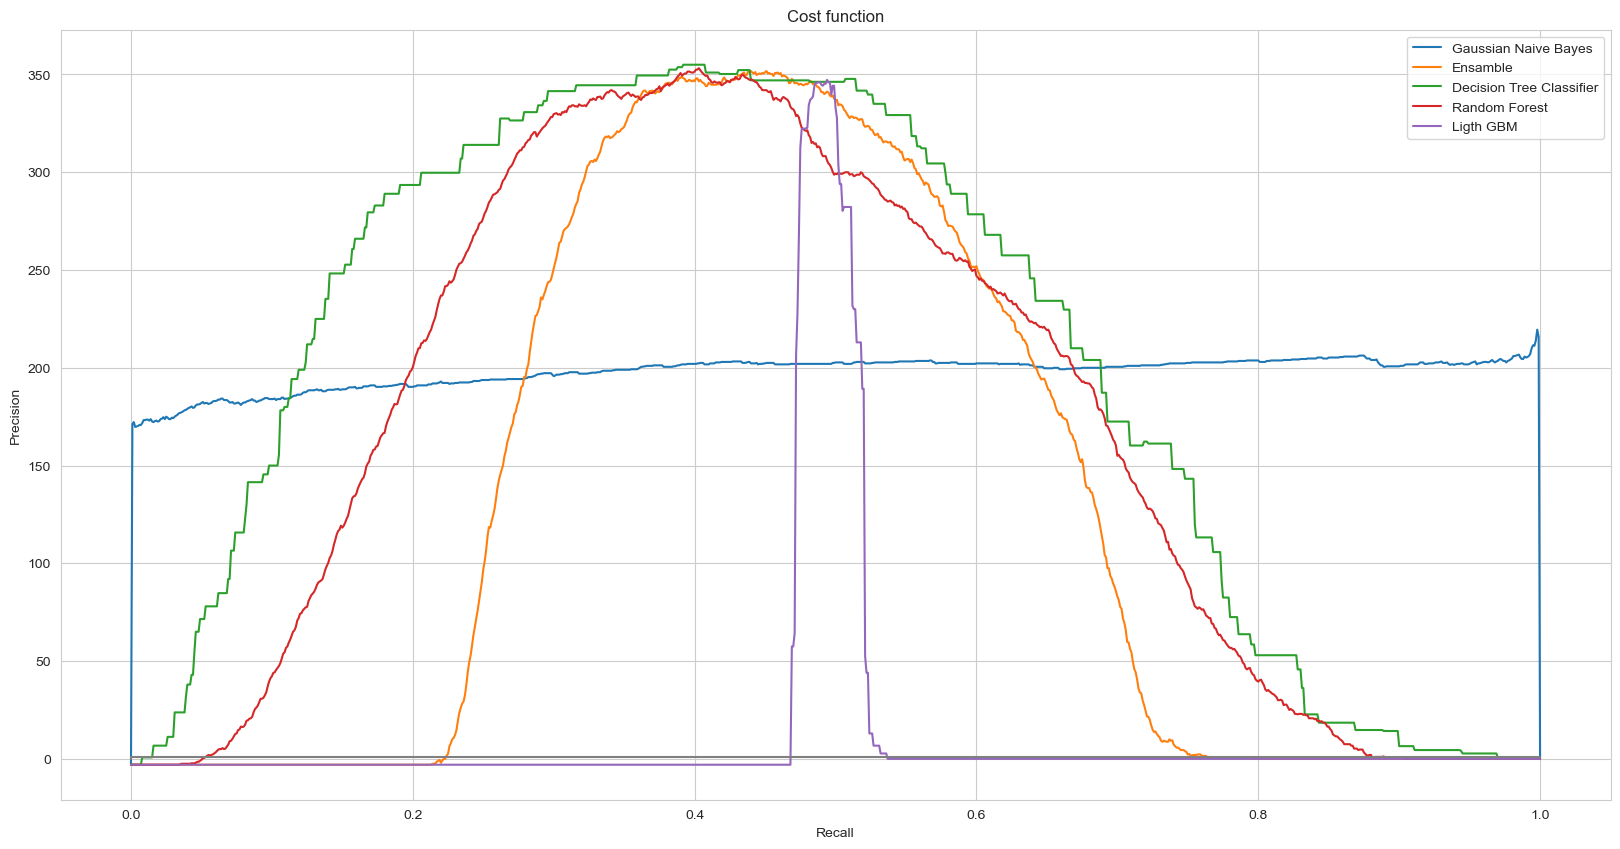

In [8]:
# Gráfico funcion de costo
sns.set_style('whitegrid')
plt.figure(figsize=(20,10))
plt.title('Cost function')

plt.plot(gaussian_cost_function["Threshold"] , gaussian_cost_function["cost_function"] ,label="Gaussian Naive Bayes")
plt.plot(ensamble_cost_function["Threshold"] , ensamble_cost_function["cost_function"] ,label="Ensamble")
plt.plot(dtree_cost_function["Threshold"] , dtree_cost_function["cost_function"] ,label="Decision Tree Classifier")
plt.plot(rforest_cost_function["Threshold"] , rforest_cost_function["cost_function"] ,label="Random Forest")
plt.plot(lgbm_cost_function["Threshold"] , lgbm_cost_function["cost_function"] ,label="Ligth GBM")

plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

<a id="33"></a> <br>
### 3.3. Métricas

In [9]:
# Concatenación de dataframes con métricas de modelos
metricas = pd.concat([gaussian_metricas,ensamble_metricas,dtree_metricas,rforest_metricas,lgbm_metricas], axis = 0)
metricas

,Models,F2 Score Train,F2 Score Test,F1 Score Train,F1 Score Test,Accuracy Score Train,Accuracy Score Test,ROC AUC Score Train,ROC AUC Score Test,Recall Score Train,Recall Score Test,Precision Score Train,Precision Score Test
0,Gausian Naive Bayes,0.600434,0.596338,0.487687,0.486056,0.628083,0.629697,0.655380,0.654055,0.709838,0.702618,0.371440,0.371539
0,Ensamble,0.706034,0.664207,0.636891,0.598949,0.783570,0.760960,0.776075,0.746019,0.761120,0.716230,0.547525,0.514673
0,Decision Tree Classifier,0.685167,0.673077,0.607166,0.599572,0.758189,0.756002,0.755236,0.748313,0.749346,0.732984,0.510335,0.507246
0,Random Forest,0.715716,0.658541,0.650894,0.603060,0.794924,0.769833,0.785472,0.747031,0.766614,0.701571,0.565528,0.528808
0,Light gbm,0.671936,0.665962,0.598481,0.592814,0.755122,0.751566,0.747340,0.742911,0.731816,0.725654,0.506244,0.501085


<a id="34"></a> <br>
### 3.4. Matriz de confusión

In [10]:
model_predict_proba_test_gaussian = gaussian_model.predict_proba(X_test)
model_pred_test_gaussian = binarize(model_predict_proba_test_gaussian, threshold = gaussian_threshold)[:,1]

model_predict_proba_test_ensamble = ensamble_model.predict_proba(X_test)
model_pred_test_ensamble = binarize(model_predict_proba_test_ensamble, threshold = ensamble_threshold)[:,1]

model_predict_proba_test_dtree = dtree_model.predict_proba(X_test)
model_pred_test_dtree = binarize(model_predict_proba_test_dtree, threshold = dtree_threshold)[:,1]

model_predict_proba_test_rforest = rforest_model.predict_proba(X_test)
model_pred_test_rforest = binarize(model_predict_proba_test_rforest, threshold = rforest_threshold)[:,1]

model_predict_proba_test_lgbm = lgbm_model.predict_proba(X_test)
model_pred_test_lgbm = binarize(model_predict_proba_test_lgbm, threshold = lgbm_threshold)[:,1]

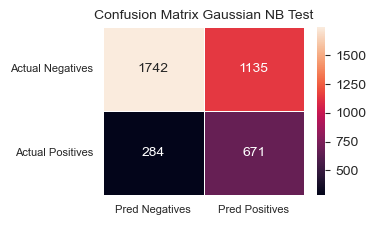

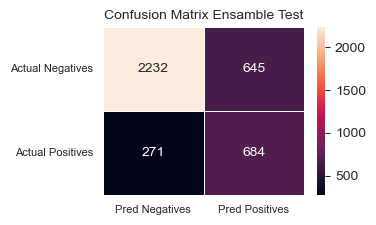

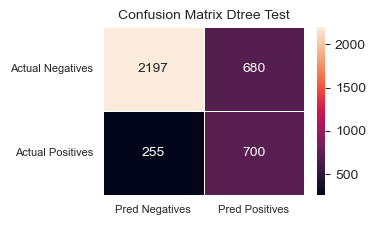

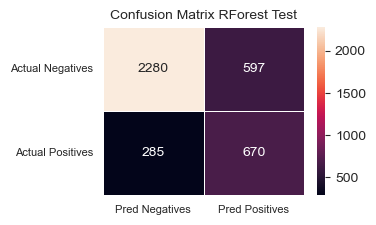

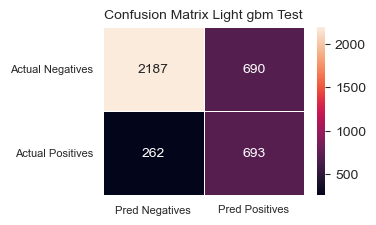

In [11]:
# Matriz de confusion gaussian NB
conf_matrix = confusion_matrix(y_test, model_pred_test_gaussian)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Gaussian NB Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion ensamble
conf_matrix = confusion_matrix(y_test, model_pred_test_ensamble)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Ensamble Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion dtree
conf_matrix = confusion_matrix(y_test, model_pred_test_dtree)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Dtree Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion random forest
conf_matrix = confusion_matrix(y_test, model_pred_test_rforest)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix RForest Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()
# Matriz de confusion light gbm
conf_matrix = confusion_matrix(y_test, model_pred_test_lgbm)
f, ax = plt.subplots(figsize=(3, 2))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.6, ax=ax)
plt.title("Confusion Matrix Light gbm Test", fontsize=10)
plt.subplots_adjust(left=0.15, right=0.99, bottom=0.15, top=0.99)
ax.set_yticks(np.arange(conf_matrix.shape[0]) + 0.5, minor=False)
ax.set_xticklabels(['Pred Negatives', 'Pred Positives'],fontsize=8, rotation=360)
ax.set_yticklabels(['Actual Negatives', 'Actual Positives'], fontsize=8, rotation=360)
plt.show()

<a id="35"></a> <br>
### 3.5. ROC Curve

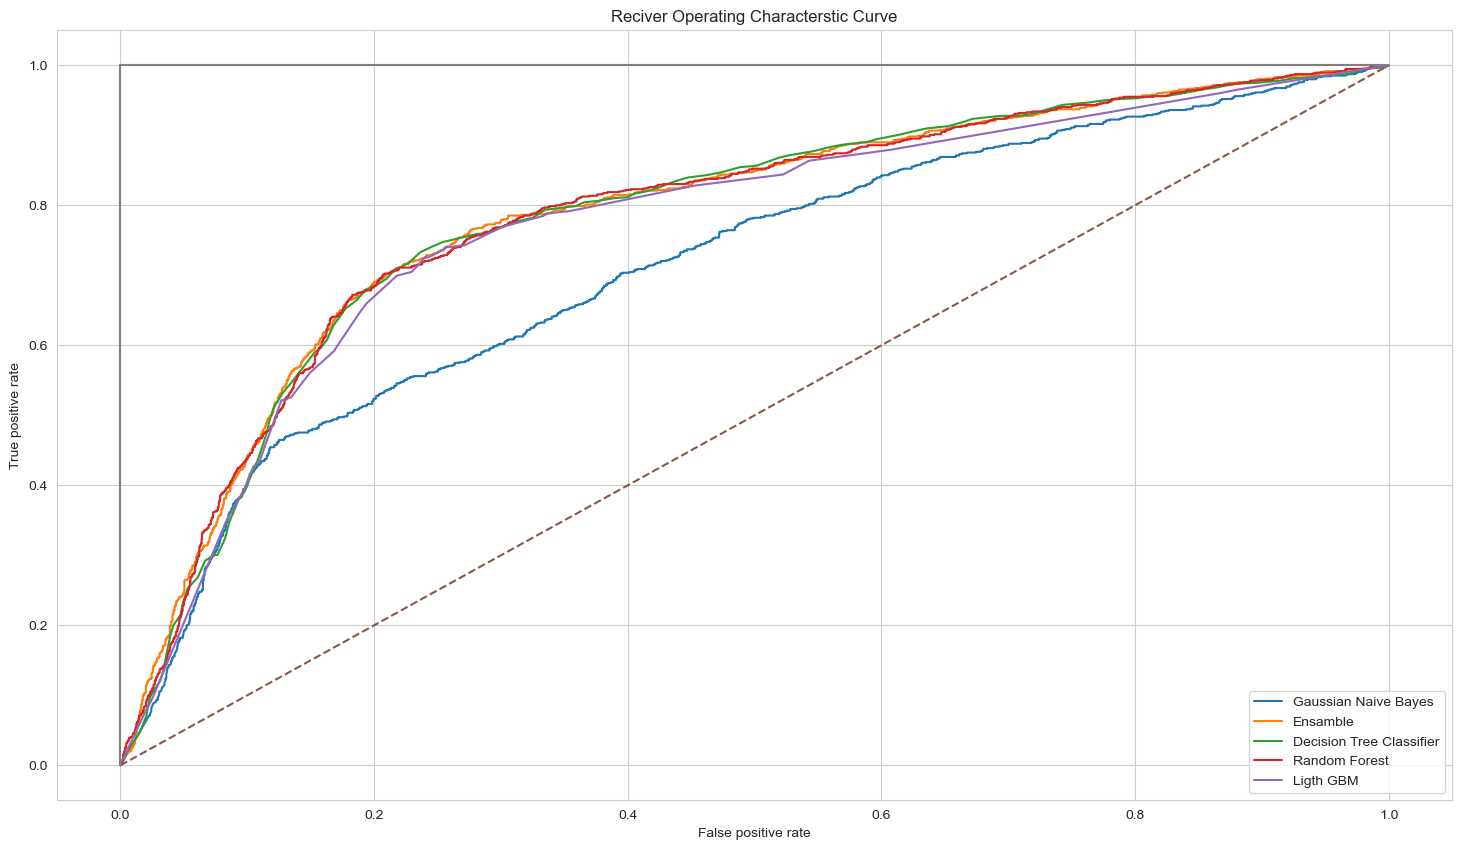

In [12]:
# Obtención de probabilidades de test
probsdmodel_gau = gaussian_model.predict_proba(X_test)
predsdmodel_gau = probsdmodel_gau[:,1]
probsdmodel_ens = ensamble_model.predict_proba(X_test)
predsdmodel_ens = probsdmodel_ens[:,1]
probsdmodel_dtree = dtree_model.predict_proba(X_test)
predsdmodel_dtree = probsdmodel_dtree[:,1]
probsdmodel_rforest = rforest_model.predict_proba(X_test)
predsdmodel_rforest = probsdmodel_rforest[:,1]
probsdmodel_lgbm = lgbm_model.predict_proba(X_test)
predsdmodel_lgbm = probsdmodel_lgbm[:,1]


# Generación de ROC curve
GNB_false_positive_rate , GNB_true_positive_rate , GNB_threshold = roc_curve(y_test ,predsdmodel_gau)
ensamble_false_positive_rate , ensamble_true_positive_rate , ensamble_threshold = roc_curve(y_test , predsdmodel_ens)
dtree_false_positive_rate , dtree_true_positive_rate , dtree_threshold = roc_curve(y_test , predsdmodel_dtree )
RForest_false_positive_rate , RForest_true_positive_rate , RForest_threshold = roc_curve(y_test , predsdmodel_rforest)
LGBM_false_positive_rate , LGBM_true_positive_rate , LGBM_threshold = roc_curve(y_test , predsdmodel_lgbm)


# Gráfico curva ROC
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Reciver Operating Characterstic Curve')

plt.plot(GNB_false_positive_rate , GNB_true_positive_rate,label="Gaussian Naive Bayes")
plt.plot(ensamble_false_positive_rate , ensamble_true_positive_rate,label="Ensamble")
plt.plot(dtree_false_positive_rate , dtree_true_positive_rate ,label="Decision Tree Classifier")
plt.plot(RForest_false_positive_rate , RForest_true_positive_rate,label="Random Forest")
plt.plot(LGBM_false_positive_rate , LGBM_true_positive_rate ,label="Ligth GBM")


plt.plot([0,1],ls='--')
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
plt.show()

<a id="36"></a> <br>
### 3.6. Precision-Recall Curve

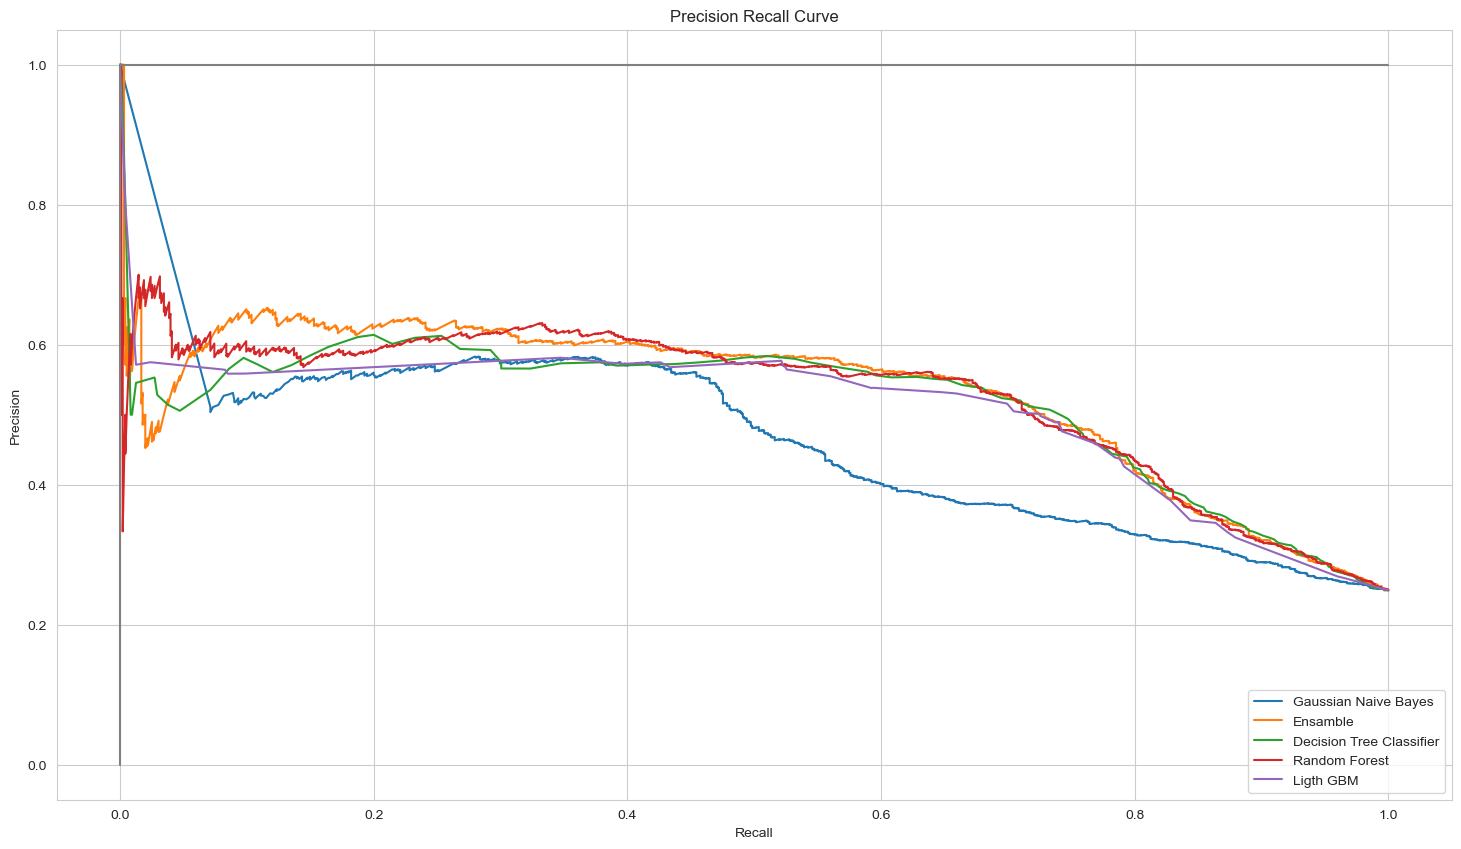

In [13]:
# Generación métricas precision, recall 
GNB_precision , GNB_recall , GNB_threshold = precision_recall_curve(y_test ,predsdmodel_gau)
ensamble_precision , ensamble_recall , ensamble_threshold = precision_recall_curve(y_test , predsdmodel_ens)
dtree_precision , dtree_recall , dtree_threshold = precision_recall_curve(y_test , predsdmodel_dtree )
RForest_precision , RForest_recall , RForest_threshold = precision_recall_curve(y_test , predsdmodel_rforest)
LGBM_precision , LGBM_recall , LGBM_threshold = precision_recall_curve(y_test , predsdmodel_lgbm)


# Gráfico curva precision recall curve
sns.set_style('whitegrid')
plt.figure(figsize=(18,10))
plt.title('Precision Recall Curve')

plt.plot(GNB_recall , GNB_precision,label="Gaussian Naive Bayes")
plt.plot(ensamble_recall , ensamble_precision,label="Ensamble")
plt.plot(dtree_recall , dtree_precision ,label="Decision Tree Classifier")
plt.plot(RForest_recall , RForest_precision,label="Random Forest")
plt.plot(LGBM_recall , LGBM_precision ,label="Ligth GBM")


plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend()
plt.show()

***
<a id="4"></a> <br>
## 4. Conclusiones y elección de modelo

**El modelo seleccionado es Decision Tree Classifier ya que tuvo un comportamiento superior en F2 Score de test, no tuvo problemas de sobreajuste, ademas de tener el maximo mas alto en la funcion de costo.
Sumado a esto, la alta interpretabilidad del modelo y el bajo requerimiento de poder de procesamiento hace que sea el modelo mas conveniente para este problema**